## Build history of ETF shares outstanding and of commodity COTs

### For ETF histories:
Several companies that manage ETFs provide histores of the NAVs and shares outstanding of their ETF products.  This notebook fetchs that history data from those websites, and assembles a Pandas DataFrame with columns:
1. symbol: like SPY or XLE
2. date: a datetime.datetime object
3. nav: the funds nav for that date
4. shares: the shares outstanding at the end of that date
5. pc: the percent change of those shares outstanding
6. share_diff: the absolute change of those shares outstanding


In [17]:
import pandas as pd
import numpy as np
import os, sys
import datetime
import jupyter_utilities as ju
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import zipfile
import urllib.request
from PIL import Image

def str_to_date(d):
    try:
        dt = datetime.datetime.strptime(str(d),'%Y-%m-%d')
    except:
        return None
    return dt

# Make important folders
TEMP_FOLDER = './temp_folder'
try:
    os.mkdir(TEMP_FOLDER)
except:
    pass
try:
    os.mkdir(f'{TEMP_FOLDER}/cot')
except:
    pass
try:
    os.mkdir(f'{TEMP_FOLDER}/zip')
except:
    pass


In [18]:
import importlib
importlib.reload(ju)

<module 'jupyter_utilities' from '/Users/bperlman1/Documents/billybyte/pyliverisk/jupyter_notebooks/cme_open_interest/jupyter_utilities.py'>

___
## First, decide if you want to re-create the ETF and COT data, or just retrieve the previously saved data DataFrames.

In [19]:
CREATE_ETF_DATA = True
# CREATE_COT_DATA = True
etf_save_path = './etf_cap_hist.csv'
# cot_save_path = './cot_history.csv'

___
### Retrieve data from iShares
Currently, you must physically download each etf history because iShares does not support csv downloads for the commoditiy ETFs.  For other funds, they do.

As an example, to process the iShares SLV (silver etf) download:
1. Download the file from the url "https://www.ishares.com/us/products/239855/ishares-silver-trust-fund/1521942788811.ajax?fileType=xls&fileName=iShares-Silver-Trust_fund&dataType=fund" to a local folder;
2. That url is actually an xml file which Microsoft Excel can convert into an xls workbook;
3. Open that file in Microsoft Excel;
4. Save the "Historical" worksheet as a csv with the file name 'etf_history.csv', where etf is something like "slv".
  * **Make sure you save the file in the folder that contains this jupyter Noteboook**
5. Execute the code below.
___

In [20]:
if CREATE_ETF_DATA:
    ishares_symbol_list = ['SLV','AGG']
    ishares_csv_list = ["./slv_history.csv",'./agg_history.csv']
    df_ishares = None
    for i in range(len(ishares_symbol_list)):
        url = ishares_csv_list[i]
        isym = ishares_symbol_list[i]
        df_temp = pd.read_csv(url)
        df_temp['symbol'] = isym
        if df_ishares is None:
            df_ishares = df_temp.copy()
        else:
            df_ishares = df_ishares.append(df_temp)
    df_ishares.head() 
    def ishares_date(d):
        try:
            dt = datetime.datetime.strptime(str(d),'%b %d, %Y')
        except:
            return None
        return dt
    df_ishares['date'] = df_ishares['As Of'].apply(ishares_date)
    df_ishares = df_ishares.rename(columns = {'NAV per Share':'nav','Shares Outstanding':'shares'})
    df_ishares = df_ishares[['symbol','date','nav','shares']]
    df_ishares = df_ishares[~df_ishares.date.isnull()].sort_values(['symbol','date'])
    df_ishares.index = list(range(len(df_ishares)))
    df_ishares.shares = df_ishares.shares.apply(lambda s:float(str(s).replace(',','')))
    df_ishares.head()


___
### Retrieve data from ProFunds using the url from accounts.profunds
___

In [21]:
if CREATE_ETF_DATA:
    profunds_symbol_list = ['UCO']
    df_profunds = None
    for psym in profunds_symbol_list:
        url = f"https://accounts.profunds.com/etfdata/ByFund/{psym}-historical_nav.csv"
        df_temp = pd.read_csv(url)
        df_temp['symbol'] = psym
        if df_profunds is None:
            df_profunds = df_temp.copy()
        else:
            df_profunds = df_profunds.append(df_temp)
    df_profunds.head()
    def profunds_date(d):
        try:
            dt = datetime.datetime.strptime(str(d),'%m/%d/%Y')
        except:
            return None
        return dt
    df_profunds.columns.values,df_profunds.head()
    df_profunds['date'] = df_profunds.Date.apply(profunds_date)
    df_profunds = df_profunds.rename(columns = {'NAV':'nav','Shares Outstanding (000)':'shares'})
    df_profunds = df_profunds[['symbol','date','nav','shares']]
    df_profunds = df_profunds[~df_profunds.date.isnull()].sort_values(['symbol','date'])
    df_profunds.index = list(range(len(df_profunds)))
    df_profunds.shares = df_profunds.shares.apply(lambda s:float(str(s).replace(',','')))
    df_profunds.head()
    

___
### Retrieve ETF data for multiple ETFs from us.spdrs.com
___

In [22]:

if CREATE_ETF_DATA:
    spdr_symbol_list = ['GLD','SPY','XLB','XLE','XLF','XLI','XLK','XLP','XLU']
    df_spdr = None
    for ssym in spdr_symbol_list:
        url = f'https://us.spdrs.com/site-content/xls/{ssym}_HistoricalNav.xls?fund={ssym}&docname=Most+Recent+NAV+%2F+NAV+History&onyx_code1=&onyx_code2='
    #     df_temp = pd.read_excel('https://us.spdrs.com/site-content/xls/SPY_HistoricalNav.xls?fund=SPY&docname=Most+Recent+NAV+%2F+NAV+History&onyx_code1=&onyx_code2=',skiprows=3)
        df_temp = pd.read_excel(url,skiprows=3)
        df_temp['symbol'] = ssym
        if df_spdr is None:
            df_spdr = df_temp.copy()
        else:
            df_spdr = df_spdr.append(df_temp)
    def spdr_date(d):
        try:
            dt = datetime.datetime.strptime(str(d),'%d-%b-%Y')
        except:
            return None
        return dt
    df_spdr['date'] = df_spdr.Date.apply(spdr_date)
    df_spdr = df_spdr.rename(columns = {'Nav':'nav','Shares Outstanding':'shares'})
    df_spdr = df_spdr[['symbol','date','nav','shares']]
    df_spdr = df_spdr[~df_spdr.date.isnull()].sort_values(['symbol','date'])
    df_spdr.index = list(range(len(df_spdr)))
    df_spdr.shares = df_spdr.shares.apply(lambda s:float(str(s).replace(',','')))
    df_spdr.head()

/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




___
### Fetch invesco ETF's from yahoo.  
1. There is no "shares" data on the Invesco site, so we will use yahoo to just get NAV's, and set shares = 0

In [23]:
if CREATE_ETF_DATA:
    invesco_symbols = [f'FX{l}' for l in 'ABCEF']

    df_invesco = None
    for invesco_symbol in invesco_symbols:
        df_temp = ju.fetch_history(invesco_symbol,datetime.datetime(2010, 1, 1), datetime.datetime.now())
        df_temp['symbol'] = invesco_symbol
        df_temp.date = df_temp.date.apply(ju.str_to_date)
        df_temp['shares'] = 0
        df_temp = df_temp.rename(columns={'close':'nav'})
        df_temp = df_temp[['symbol','date','nav','shares']]
        if df_invesco is None:
            df_invesco = df_temp.copy()
        else:
            df_invesco = df_invesco.append(df_temp)
    df_invesco.tail()    


___
### Combine the 3 separate dataframes into one and save it
1. Append df_ishares, df_profunds and df_spdr rows together;
2. Save the combined DataFrame to ./etf_cap_hist.csv;
3. Read that csv back into the DataFrame dff
___

In [24]:

if CREATE_ETF_DATA:
    df_all = df_ishares.copy()
    df_all = df_all.append(df_profunds,ignore_index=True)
    df_all = df_all.append(df_spdr,ignore_index=True)
    df_all = df_all.append(df_invesco,ignore_index=True)
    df_all.index = list(range(len(df_all)))
    df_all.to_csv(etf_save_path,index=False)


In [25]:
set(df_all.symbol)

{'AGG',
 'FXA',
 'FXB',
 'FXC',
 'FXE',
 'FXF',
 'GLD',
 'SLV',
 'SPY',
 'UCO',
 'XLB',
 'XLE',
 'XLF',
 'XLI',
 'XLK',
 'XLP',
 'XLU'}

___
### Create the following columns:
1. pc: shares daily percent change
2. share_diff: daily difference from the shares column
___

In [26]:
dff  = pd.read_csv(etf_save_path)
dff['date'] = dff.date.apply(str_to_date)
df_fund_flows = dff.copy()
df_fund_flows['shares'] = df_fund_flows.shares.apply(lambda s:float(str(s).replace(',','')))
df_fund_flows = df_fund_flows.sort_values(['symbol','date'])
symbol_list = list(set(df_fund_flows.symbol))
df_final = None
for sym in symbol_list:
    df_this_sym= df_fund_flows[df_fund_flows.symbol==sym]
    df_this_sym['pc'] = df_this_sym.shares.pct_change()
    df_this_sym['share_diff'] = df_this_sym.shares.diff()
    df_this_sym = df_this_sym[df_this_sym.pc.notnull()]
    if df_final is None:
        df_final = df_this_sym.copy()
    else:
        df_final = df_final.append(df_this_sym)

/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



___
### Create the group_by Dataframes:
1. df_pc_gb: shows the min and max per symbol of the pc column;
2. df_share_diff_gb: shows the min and max per symbol of the share_diff column.
___

In [27]:
dt_beg = datetime.datetime.now() - datetime.timedelta(1000)
df_final2 = df_final[(df_final.date>dt_beg)]
df_pc = df_final2[['symbol','pc']] 
df_pc_gb = df_pc.groupby('symbol',as_index=False).agg({'pc':[min,max]})
df_pc_gb.columns = ['symbol'] + [ t[0]+ '_' + t[1] for t in df_pc_gb.columns.values[1:]]
df_share_diff = df_final2[['symbol','share_diff']] 
df_share_diff_gb = df_share_diff.groupby('symbol',as_index=False).agg({'share_diff':[min,max]})
df_share_diff_gb.columns = ['symbol'] + [ t[0]+ '_' + t[1] for t in df_share_diff_gb.columns.values[1:]]
df_pc_gb,df_share_diff_gb

(   symbol    pc_min    pc_max
 0     AGG -0.035802  0.027816
 1     GLD -0.014993  0.045716
 2     SLV -0.012525  0.019622
 3     SPY -0.031141  0.033968
 4     UCO -0.083000  0.174258
 5     XLB -0.078787  0.139210
 6     XLE -0.052752  0.066848
 7     XLF -0.037057  0.042228
 8     XLI -0.061951  0.074371
 9     XLK -0.143055  0.141095
 10    XLP -0.060963  0.072662
 11    XLU -0.069080  0.070759,    symbol  share_diff_min  share_diff_max
 0     AGG     -19000000.0      14000000.0
 1     GLD      -4100000.0      11900000.0
 2     SLV      -4150000.0       6600000.0
 3     SPY     -30900000.0      34200000.0
 4     UCO         -3425.0          6550.0
 5     XLB      -6100000.0       9400000.0
 6     XLE     -10200000.0      11700000.0
 7     XLF     -39850000.0      40600000.0
 8     XLI      -9300000.0       8800000.0
 9     XLK     -50950000.0      44100000.0
 10    XLP     -10900000.0      14000000.0
 11    XLU     -12550000.0      11600000.0)

In [28]:
df_final2.columns.values

array(['symbol', 'date', 'nav', 'shares', 'pc', 'share_diff'],
      dtype=object)

___
### Create a DataFrame that has the pc of each security in a separate column.
This dataframe will make it easy to graph histograms of the pc values
___

In [29]:
df_pc_all = None
for sym in list(set(df_final2.symbol)):
    df_temp = df_final2[df_final2.symbol==sym][['date','pc']]
    df_temp = df_temp.rename(columns={'pc':sym})
    if df_pc_all is None:
        df_pc_all = df_temp.copy()
    else:
        df_pc_all = df_pc_all.merge(df_temp,how='inner',on='date')
df_pc_all.index = df_pc_all.date
df_pc_all = df_pc_all[list(filter(lambda c:'date' not in c,df_pc_all.columns.values))]

In [30]:
df_pc_all.columns.values,df_pc_all.as_matrix().shape

/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



(array(['XLU', 'XLB', 'UCO', 'XLI', 'AGG', 'XLP', 'GLD', 'SPY', 'XLF',
        'XLK', 'XLE', 'SLV'], dtype=object), (557, 12))

___
### Graph histograms of the pc column
___

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a499400>,
      dtype=object)

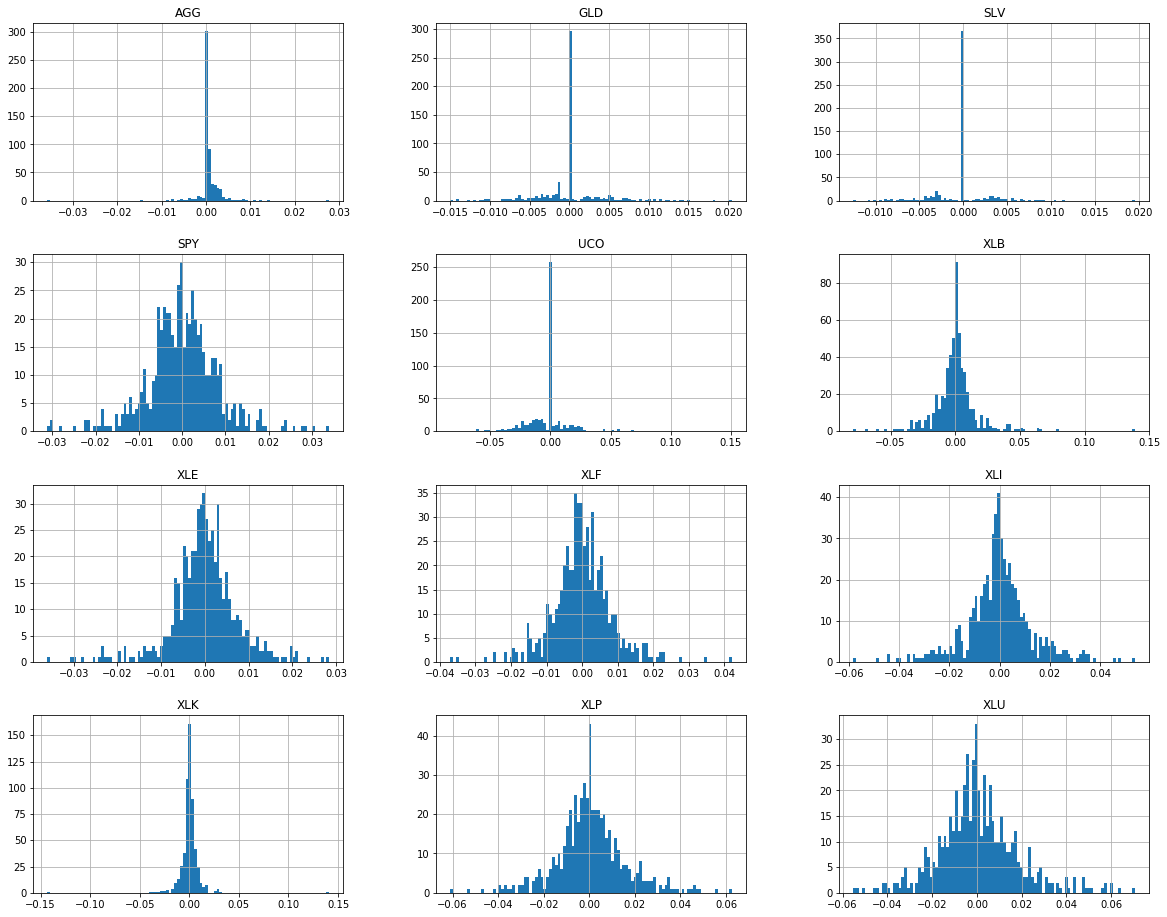

In [31]:
df_pc_all.hist(bins=100,figsize=(20,16))

### Show frequency of outlier changes in shares outstanding in GLD

In [32]:
djan1 = datetime.datetime(2018,1,1)
djan2 = datetime.datetime(2019,2,28)
c1 = df_final2.symbol=='GLD'
c2 = df_final2.date>=djan1
c3 = df_final2.date<=djan2
c4 = df_final2.pc >= .009
allc = (c1) & (c2) & (c3) & (c4)
df_final2[allc]

,symbol,date,nav,shares,pc,share_diff
13153,GLD,2018-01-18,126.419184,284800000.0,0.014245,4000000.0
13194,GLD,2018-03-19,124.458023,288400000.0,0.012640,3600000.0
13337,GLD,2018-10-10,112.461736,251000000.0,0.012097,3000000.0
13385,GLD,2018-12-18,117.833453,262400000.0,0.010786,2800000.0
13390,GLD,2018-12-26,119.236762,268600000.0,0.020517,5400000.0
13394,GLD,2019-01-02,121.274806,270400000.0,0.009709,2600000.0
13406,GLD,2019-01-18,121.376456,275400000.0,0.015112,4100000.0
13412,GLD,2019-01-29,123.569123,280200000.0,0.010094,2800000.0


## END